In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from ae import Autoencoder
import torch.nn as nn

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor and scale to [0, 1]
])

## Downloading the MNIST dataset

In [3]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,          # Load test set
    download=True,
    transform=transform
)

## Creating dataloaders and displaying sample image

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the download by printing some info
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize a sample image
sample_image, sample_label = train_dataset[0]  # Get the first image and label
print(f"Sample image shape: {sample_image.shape}")  # Should be [1, 28, 28]
print(f"Sample label: {sample_label}")

Training set size: 60000
Test set size: 10000
Sample image shape: torch.Size([1, 28, 28])
Sample label: 5


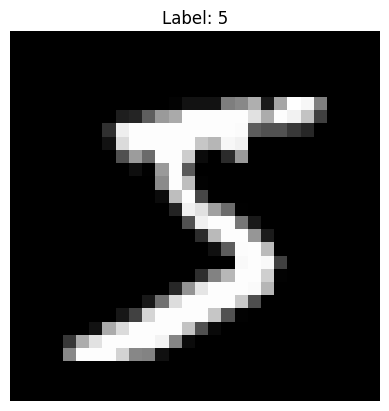

In [5]:
# Plot the sample image
plt.imshow(sample_image.squeeze(), cmap='gray')  # Squeeze removes the channel dim for plotting
plt.title(f"Label: {sample_label}")
plt.axis('off')  # Hide axes
plt.show()

## Declarations

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convChannels = (1, 4, 4, 4, 4)
convKernels =   (3, 3, 2, 2)
convStrides =   (1, 1, 2, 2)
convPadding =   (1, 1, 0, 0)

# AutoEncoder
ae = Autoencoder(convChannels, convKernels, convStrides, convPadding).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Main Training Loop

In [7]:
losses = []
iterations = []
max_epochs = 10

ae.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move images to GPU
        images = images.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = ae(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f"Epoch: {epoch}, Loss: {loss.detach()}")

print(f"Final Loss: {loss.detach()}")

Epoch: 0, Loss: 0.2473059445619583
Epoch: 1, Loss: 0.004464268684387207
Epoch: 2, Loss: 0.002827416406944394
Epoch: 3, Loss: 0.003069644095376134
Epoch: 4, Loss: 0.0028311293572187424
Epoch: 5, Loss: 0.002310731913894415
Epoch: 6, Loss: 0.0023005707189440727
Epoch: 7, Loss: 0.0021366896107792854
Epoch: 8, Loss: 0.0021898532286286354
Epoch: 9, Loss: 0.0022036961745470762
Final Loss: 0.0021109355147928


## Displaying Examples

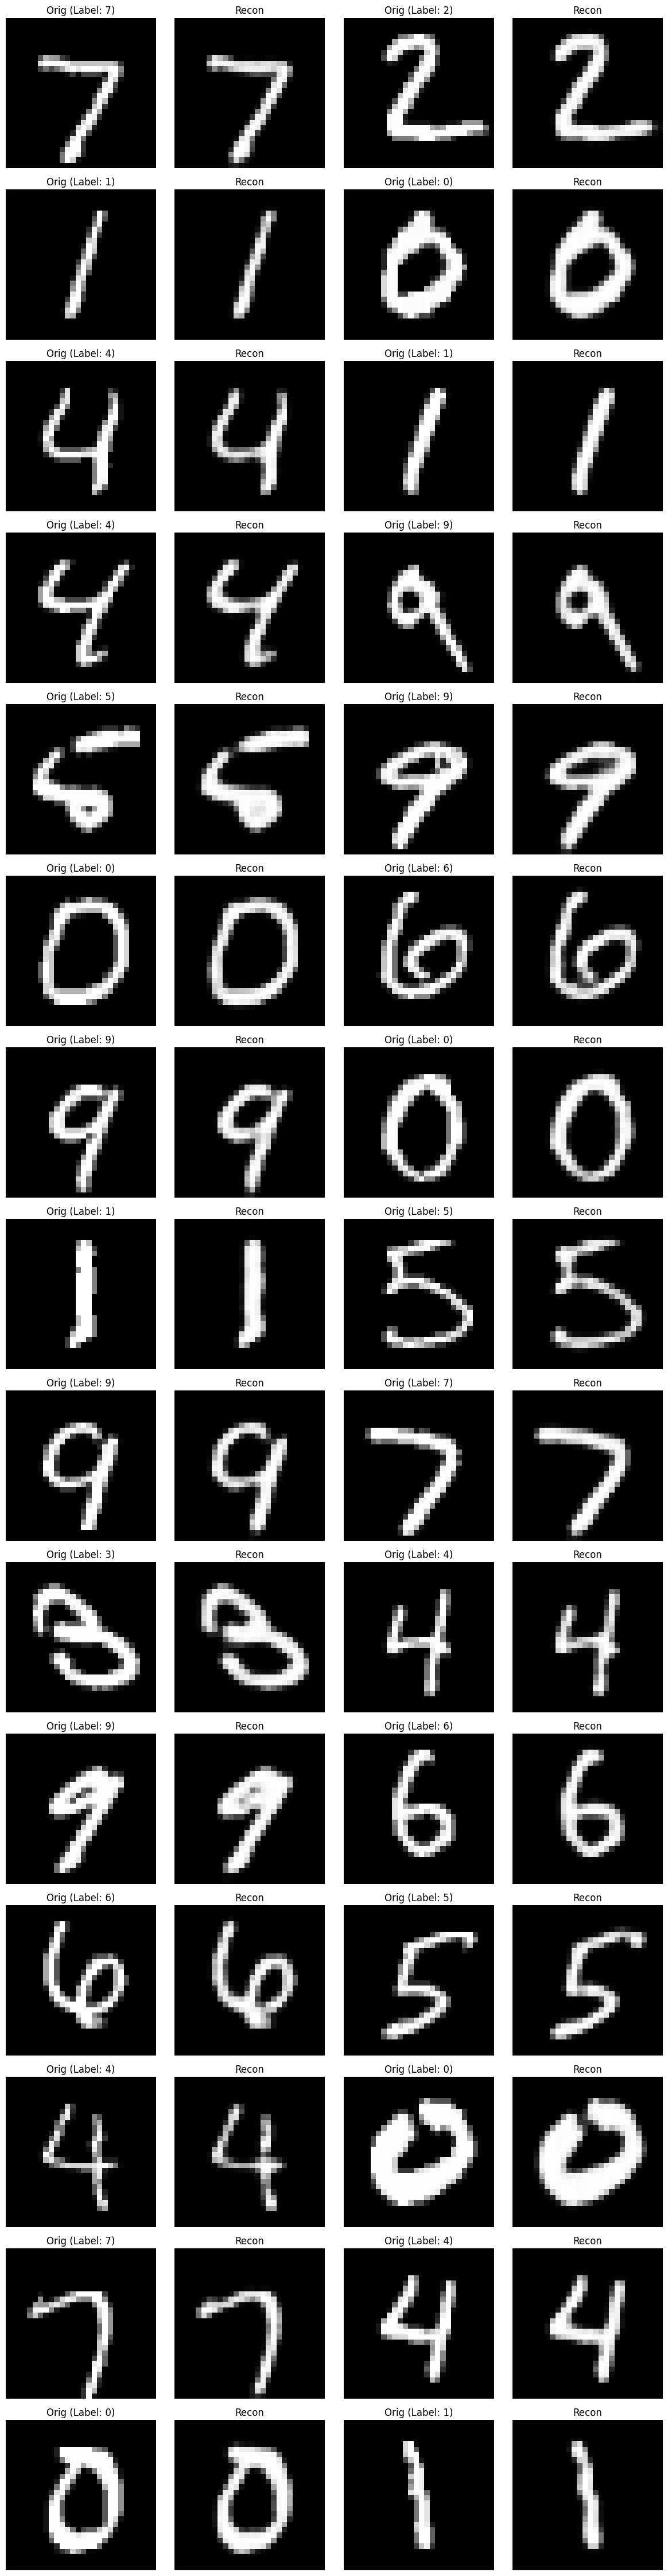

In [10]:
# Assuming ae, test_dataset, and device are already defined
num_examples = 30
pairs_per_row = 2  # Two pairs (4 images) per row
rows = (num_examples + pairs_per_row - 1) // pairs_per_row  # Ceiling division: 2 rows for 5 examples

ae.eval()

with torch.no_grad():
    # Create a figure with rows and 4 columns
    fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))  # 4 columns for 2 pairs
    
    for i in range(num_examples):
        # Calculate row and column indices
        row_idx = i // pairs_per_row
        pair_idx = i % pairs_per_row
        col_idx = pair_idx * 2  # 0 or 2 for each pair’s original

        # Get the original image and label
        image, label = test_dataset[i]
        image = image.to(device).unsqueeze(dim=0)

        # Get the reconstructed image
        reconstructed_image = ae(image)

        # Move to CPU and squeeze
        image = image.squeeze().to('cpu')
        reconstructed_image = reconstructed_image.squeeze().to('cpu')

        # Plot original image
        axes[row_idx, col_idx].imshow(image, cmap='gray')
        axes[row_idx, col_idx].set_title(f"Orig (Label: {label})")
        axes[row_idx, col_idx].axis('off')

        # Plot reconstructed image
        axes[row_idx, col_idx + 1].imshow(reconstructed_image, cmap='gray')
        axes[row_idx, col_idx + 1].set_title("Recon")
        axes[row_idx, col_idx + 1].axis('off')

    # Hide empty subplots (if num_examples doesn’t fill all columns)
    for i in range(num_examples, rows * pairs_per_row):
        row_idx = i // pairs_per_row
        col_idx = (i % pairs_per_row) * 2
        axes[row_idx, col_idx].axis('off')      # Hide original slot
        axes[row_idx, col_idx + 1].axis('off')  # Hide reconstructed slot

    # Adjust layout and display
    plt.tight_layout()
    plt.show()